In [1]:
from collections import defaultdict
import json
import numpy as np
import os
import pandas as pd

In [2]:
import plotting_utils
import matplotlib.pyplot as plt
import seaborn as sns

plotting_utils.setup_plotting_params()

In [3]:
RUNDIR = "../../benchmarking/benchmark_output/runs/latest"

In [4]:
num_gpus = {
    "gooseai_gpt-j-6b": 1,
    "together_gpt-j-6b": 1,
    "gooseai_gpt-neo-20b": 1,
    "together_gpt-neox-20b": 1,
    "openai_ada": 1,
    "openai_curie": 1,
    "openai_davinci": 8,
    "together_opt-175b": 8,
    "ai21_j1-large": 1,
    "ai21_j1-grande": 1,
    "ai21_j1-jumbo": 8,
    "mt_nlg": 24,
    "anthropic_stanford-online-all-v4-s3": 4,
    "together_bloom": 8,
    "together_opt-66b": 4,
    "together_yalm": 4,
}
colors = {
    "together_gpt-j-6b": 'orange',
    "together_gpt-neox-20b": 'brown',
    "openai_davinci": 'blue',
    "together_opt-175b": 'green',
    "ai21_j1-large": 'pink',
    "ai21_j1-grande": 'purple',
    "ai21_j1-jumbo": 'grey',
    "mt_nlg": 'black',
    "anthropic_stanford-online-all-v4-s3": 'magenta',
    "together_bloom": 'red',
    "together_opt-66b": 'aqua',
    "together_yalm": 'skyblue',
}
model_configs = {
    "gooseai_gpt-j-6b": (4096, 28),
    "together_gpt-j-6b": (4096, 28),
    "gooseai_gpt-neo-20b": (6144, 44),
    "together_gpt-neox-20b": (6144, 44),
    "openai_ada": (1024, 24),
    "openai_curie": (4096, 32),
    "openai_davinci": (12288, 96),
    "together_opt-175b": (12288, 96),
    "ai21_j1-large": (4096, 32),
    "ai21_j1-grande": (5120, 50),
    "ai21_j1-jumbo": (13824, 76),
    "mt_nlg": (20480, 105),
    "anthropic_stanford-online-all-v4-s3": (8192, 64),
    "together_bloom": (14336, 70),
    "together_opt-66b": (9216, 64),
    "together_yalm": (10240, 80),
} 
names = {
    "together_gpt-j-6b": 'GPT-J',
    "together_gpt-neox-20b": 'GPT-NeoX',
    "openai_curie": 'OpenAI/curie',
    "openai_davinci": 'OpenAI/davinci',
    "together_opt-175b": 'OPT (175B)',
    "ai21_j1-large": 'AI21/J1-Large',
    "ai21_j1-grande": 'AI21/J1-Grande',
    "ai21_j1-jumbo": 'AI21/J1-Jumbo',
    "mt_nlg": 'Microsoft/NLG-530B',
    "anthropic_stanford-online-all-v4-s3": 'Anthropic',
    "together_bloom": 'BLOOM',
    "together_opt-66b": 'OPT (66B)',
    "together_yalm": 'YALM',
}
# Using GCP price: https://cloud.google.com/compute/vm-instance-pricing#a2-machine-types.
# Using GCP because AWS and Azure only seem to provide 8-A100 GPU machines.
cost_of_a100_gpu_per_hour = 3.67

In [5]:
class Run:
    def __init__(self, key):
        scenario, args = key.split(":")
        args = args.split(",")
        self.scenario = scenario
        for arg in args:
            k, v = arg.split("=")
            setattr(self, k, v)
            
        self.runtimes = []
        self.idealized_runtimes = []
        self.denoised_runtimes = []
        self.idealized_costs = []
        self.exact_match = []
        self.num_prompt_tokens = []
        self.num_output_tokens = []
        self.flops = []
        with open(os.path.join(RUNDIR, key, "per_instance_stats.json"), "r") as f:
            all_instance_stats = json.load(f)
            for per_instance_stats in all_instance_stats:
                stats = per_instance_stats["stats"]
                for stat in stats:
                    if stat["name"]["name"] == "inference_runtime":
                        self.runtimes.append(float(stat["mean"]))
                    elif stat["name"]["name"] == "inference_denoised_runtime":
                        self.denoised_runtimes.append(float(stat["mean"]))
                    elif stat["name"]["name"] == "inference_idealized_runtime":
                        if stat["count"] > 0:
                            self.idealized_runtimes.append(float(stat["mean"]))
                            if self.model in num_gpus:
                                self.idealized_costs.append(
                                    self.idealized_runtimes[-1] * cost_of_a100_gpu_per_hour *
                                    num_gpus[self.model] / 36.0)
                    elif stat["name"]["name"] == "exact_match":
                        self.exact_match.append(stat["mean"])
                    elif stat["name"]["name"] == "num_prompt_tokens":
                        self.num_prompt_tokens.append(stat["mean"])
                    elif stat["name"]["name"] == "num_output_tokens":
                        self.num_output_tokens.append(stat["mean"])
        for (num_prompt_tokens, num_output_tokens) in zip(
            self.num_prompt_tokens, self.num_output_tokens):
            if self.model not in model_configs:
                self.flops.append(None)
            else:
                (h, num_layers) = model_configs[self.model]
                flops = 24 * h**2 * (num_prompt_tokens + num_output_tokens - 1) * num_layers
                self.flops.append(flops)

In [6]:
runs = []
for run_key in os.listdir(RUNDIR):
    if (
        run_key.startswith("mmlu:subject=college_chemistry")
        or run_key.startswith("imdb")
        or run_key.startswith("raft:subset=terms_of_service")
        or run_key.startswith("boolq")
    ):
        if "only_contrast" in run_key:
            continue
        run = Run(run_key)
        if (
            run.model == "together_gpt-neox-20b"
            or run.model == "openai_ada"
            or run.model == "together_opt-66b"
            or run.model == "openai_curie"
        ):
            continue
        runs.append(Run(run_key))

In [7]:
runs_grouped_by_scenario = defaultdict(list)
for run in runs:
    if run.scenario == "mmlu":
        scenario = f"mmlu:subject={run.subject}"
    elif run.scenario == "raft":
        scenario = f"raft:subset={run.subset}"
    elif run.scenario == "natural_qa":
        scenario = f"natural_qa:model={run.mode}"
    elif run.scenario == "civil_comments":
        scenario = f"civil_comments:demographic={run.demographic}"
    elif run.scenario == "babi_qa":
        scenario = f"babi_qa:task={run.task}"
    elif run.scenario == "entity_matching":
        scenario = f"entity_matching:dataset={run.dataset}"
    elif run.scenario == "synthetic_reasoning":
        scenario = f"synthetic_reasoning:mode={run.mode}"
    elif run.scenario == "imdb" or run.scenario == 'boolq':
        if getattr(run, 'only_contrast', None) is None:
            scenario = run.scenario
        else:
            scenario = f"{run.scenario}:only_contrast={getattr(run, 'only_contrast')}"
    else:
        scenario = run.scenario
    runs_grouped_by_scenario[scenario].append(run)

In [8]:
rankings_per_scenario = {}
for scenario in runs_grouped_by_scenario:
    scores = []
    for run in runs_grouped_by_scenario[scenario]:
        accuracy = np.mean(run.exact_match)
        if len(run.exact_match) == 0 or len(run.idealized_runtimes) == 0:
            continue
        idealized_runtime = np.mean(run.idealized_runtimes)
        scores.append((run.model, accuracy / idealized_runtime))
    scores.sort(key=lambda x: x[1], reverse=True)
    rankings_per_scenario[scenario] = scores

In [9]:
for scenario in rankings_per_scenario:
    print(scenario)
    print(rankings_per_scenario[scenario])
    print()

raft:subset=terms_of_service
[('ai21_j1-grande', 3.6068160699545118), ('together_gpt-j-6b', 2.0734766502737534), ('ai21_j1-jumbo', 1.9801722881994919), ('anthropic_stanford-online-all-v4-s3', 1.907101965339008), ('ai21_j1-large', 1.7302047284994575), ('openai_davinci', 0.7710201537677497), ('together_bloom', 0.4446831821563547), ('together_yalm', 0.26220538441696717), ('together_opt-175b', 0.22515830580766405)]

imdb
[('ai21_j1-large', 7.391697528156975), ('together_gpt-j-6b', 4.344975197315889), ('ai21_j1-grande', 3.4569004470996108), ('anthropic_stanford-online-all-v4-s3', 2.689556502978986), ('ai21_j1-jumbo', 2.110861076554773), ('together_bloom', 1.112016584335111), ('together_opt-175b', 1.0795524875045979), ('openai_davinci', 1.0191515104985185), ('together_yalm', 0.4848972299898609)]

mmlu:subject=college_chemistry
[('ai21_j1-large', 6.747977150275187), ('together_gpt-j-6b', 4.3678433075541365), ('anthropic_stanford-online-all-v4-s3', 3.25850331398548), ('ai21_j1-grande', 2.36017

In [10]:
all_models = set()
for scenario in rankings_per_scenario:
    for (model, score) in rankings_per_scenario[scenario]:
        all_models.add(model)
model_ids = {model: i for i, model in enumerate(sorted(all_models))}
numerical_rankings_per_scenario = {}
string_rankings_per_scenario = {}
for scenario in rankings_per_scenario:
    numerical_rankings_per_scenario[scenario] = [model_ids[model] for model, _ in rankings_per_scenario[scenario]]
    string_rankings_per_scenario[scenario] = [model for model, _ in rankings_per_scenario[scenario]]
    print(scenario)
    print(numerical_rankings_per_scenario[scenario])
    print()
for scenario in rankings_per_scenario:
    print(scenario)
    print(string_rankings_per_scenario[scenario])
    print()

raft:subset=terms_of_service
[0, 6, 1, 3, 2, 4, 5, 8, 7]

imdb
[2, 6, 0, 3, 1, 5, 7, 4, 8]

mmlu:subject=college_chemistry
[2, 6, 3, 0, 7, 1, 4, 5, 8]

boolq
[2, 6, 3, 0, 1, 5, 7, 4, 8]

raft:subset=terms_of_service
['ai21_j1-grande', 'together_gpt-j-6b', 'ai21_j1-jumbo', 'anthropic_stanford-online-all-v4-s3', 'ai21_j1-large', 'openai_davinci', 'together_bloom', 'together_yalm', 'together_opt-175b']

imdb
['ai21_j1-large', 'together_gpt-j-6b', 'ai21_j1-grande', 'anthropic_stanford-online-all-v4-s3', 'ai21_j1-jumbo', 'together_bloom', 'together_opt-175b', 'openai_davinci', 'together_yalm']

mmlu:subject=college_chemistry
['ai21_j1-large', 'together_gpt-j-6b', 'anthropic_stanford-online-all-v4-s3', 'ai21_j1-grande', 'together_opt-175b', 'ai21_j1-jumbo', 'openai_davinci', 'together_bloom', 'together_yalm']

boolq
['ai21_j1-large', 'together_gpt-j-6b', 'anthropic_stanford-online-all-v4-s3', 'ai21_j1-grande', 'ai21_j1-jumbo', 'together_bloom', 'together_opt-175b', 'openai_davinci', 'togethe

In [12]:
rank_per_model = defaultdict(list)
for model in model_ids:
    for scenario in numerical_rankings_per_scenario:
        rank_per_model[model].append(
            numerical_rankings_per_scenario[scenario].index(model_ids[model])
        )
ranks = []
for model in rank_per_model:
    ranks.append(
        (
            model,
            np.min(rank_per_model[model]),
            np.mean(rank_per_model[model]),
            np.max(rank_per_model[model]),
            np.std(rank_per_model[model]),
        )
    )
ranks.sort(key=lambda x: (x[2], x[4]))
for i, (model, min_rank, mean_rank, max_rank, std) in enumerate(ranks):
    print(
        f"{i}) model={model}, min rank = {min_rank}, mean rank={mean_rank}, max rank={max_rank}, std={std}"
    )

0) model=together_gpt-j-6b, min rank = 1, mean rank=1.0, max rank=1, std=0.0
1) model=ai21_j1-large, min rank = 0, mean rank=1.0, max rank=4, std=1.7320508075688772
2) model=ai21_j1-grande, min rank = 0, mean rank=2.0, max rank=3, std=1.224744871391589
3) model=anthropic_stanford-online-all-v4-s3, min rank = 2, mean rank=2.5, max rank=3, std=0.5
4) model=ai21_j1-jumbo, min rank = 2, mean rank=3.75, max rank=5, std=1.0897247358851685
5) model=together_bloom, min rank = 5, mean rank=5.75, max rank=7, std=0.82915619758885
6) model=together_opt-175b, min rank = 4, mean rank=6.0, max rank=8, std=1.4142135623730951
7) model=openai_davinci, min rank = 5, mean rank=6.25, max rank=7, std=0.82915619758885
8) model=together_yalm, min rank = 7, mean rank=7.75, max rank=8, std=0.4330127018922193


In [13]:
print(ranks[::-1])

[('together_yalm', 7, 7.75, 8, 0.4330127018922193), ('openai_davinci', 5, 6.25, 7, 0.82915619758885), ('together_opt-175b', 4, 6.0, 8, 1.4142135623730951), ('together_bloom', 5, 5.75, 7, 0.82915619758885), ('ai21_j1-jumbo', 2, 3.75, 5, 1.0897247358851685), ('anthropic_stanford-online-all-v4-s3', 2, 2.5, 3, 0.5), ('ai21_j1-grande', 0, 2.0, 3, 1.224744871391589), ('ai21_j1-large', 0, 1.0, 4, 1.7320508075688772), ('together_gpt-j-6b', 1, 1.0, 1, 0.0)]


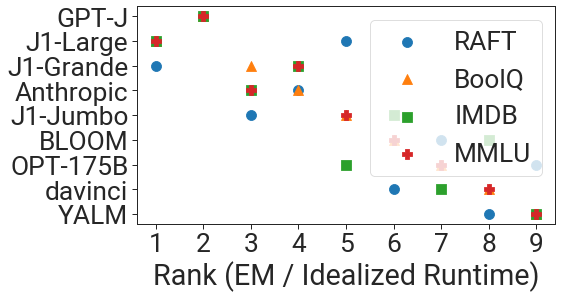

In [14]:
plt.figure(figsize=(7.5, 4))
labels = ["RAFT", "BoolQ", "IMDB", "MMLU"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:4]
markers = ["o", "^", "s", "P"]
model_display_names = {
    "together_yalm": "YALM",
    "openai_davinci": "davinci",
    "together_opt-175b": "OPT-175B",
    "ai21_j1-grande": "J1-Grande",
    "ai21_j1-large": "J1-Large",
    "ai21_j1-jumbo": "J1-Jumbo",
    "anthropic_stanford-online-all-v4-s3": "Anthropic",
    "together_gpt-j-6b": "GPT-J",
    "together_bloom": "BLOOM",
}
for i, data in enumerate(ranks[::-1]):
    model = data[0]
    for j, scenario in enumerate(list(numerical_rankings_per_scenario.keys())):
        if i == len(ranks) - 1:
            plt.scatter(
                rank_per_model[model][j] + 1,
                i,
                label=labels[j],
                marker=markers[j],
                color=colors[j],
            )
        else:
            plt.scatter(
                rank_per_model[model][j] + 1,
                i,
                marker=markers[j],
                color=colors[j],
            )
plt.yticks(
    list(range(len(ranks))), [model_display_names[data[0]] for data in ranks[::-1]]
)
plt.xlabel("Rank (EM / Idealized Runtime)")
plt.xticks(list(range(1, len(ranks) + 1)))
plt.legend()